Cargando datos de radiación para: Verano Año 1...
Datos cargados: 8777948 mediciones.
Tomando una muestra de 250000 puntos...
Datos listos para graficar.
Generando el gráfico y guardando en 'grafico_06_distribucion_radiacion_verano.png'...


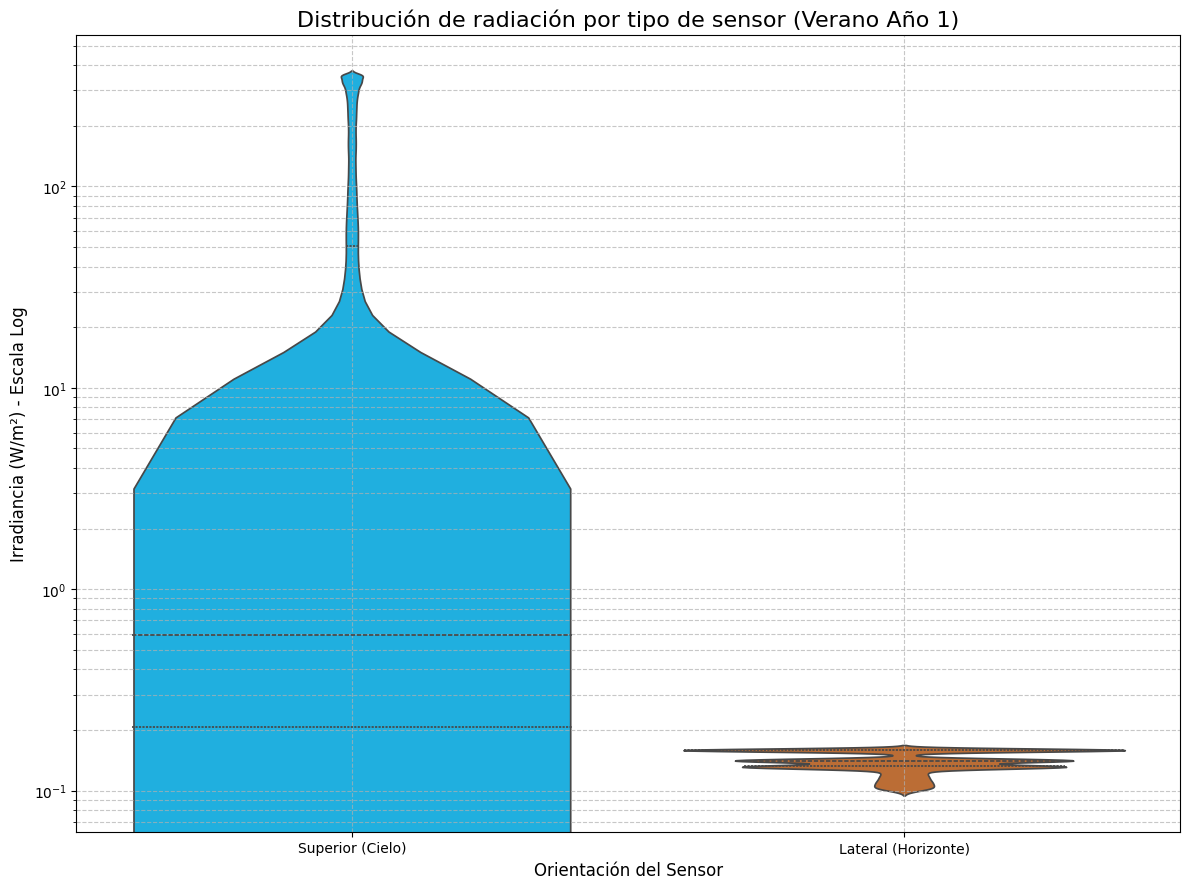

Proceso finalizado. El gráfico fue guardado en 'grafico_06_distribucion_radiacion_verano.png'.


In [6]:
# -*- coding: utf-8 -*-
"""
Análisis de la distribución de radiación del sensor RDS para una estación,
utilizando una escala logarítmica para una mejor visualización.
VERSIÓN SEGURA PARA RAM.
"""
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1. CONFIGURACIÓN DEL GRÁFICO Y ANÁLISIS ---

# Parámetros del gráfico
TAMAÑO_FIGURA = (12, 9)
RESOLUCION_DPI = 300
NOMBRE_ARCHIVO_SALIDA = "grafico_06_distribucion_radiacion_verano.png"

# Parámetros del análisis
ARCHIVO_CALIBRADO = 'dataset_meda_calibrated_data.parquet'
NOMBRE_ESTACION = "Verano Año 1"
SOL_INICIO = 194
SOL_FIN = 372
TAMAÑO_MUESTRA = 250000

# --- 2. CARGA Y PREPARACIÓN DE DATOS ---
print(f"Cargando datos de radiación para: {NOMBRE_ESTACION}...")
try:
    columnas_rds = [f'RDS_TOP_{i}' for i in range(1, 9)] + [f'RDS_LAT_{i}' for i in range(1, 9)] + ['sol']
    
    df_estacion = pd.read_parquet(
        ARCHIVO_CALIBRADO,
        engine='pyarrow',
        filters=[('sol', '>=', SOL_INICIO), ('sol', '<=', SOL_FIN)],
        columns=columnas_rds
    )
    print(f"Datos cargados: {len(df_estacion)} mediciones.")

    # Muestreamos ANTES de la operación 'melt' para proteger la RAM
    if len(df_estacion) > TAMAÑO_MUESTRA:
        print(f"Tomando una muestra de {TAMAÑO_MUESTRA} puntos...")
        df_muestra = df_estacion.sample(n=TAMAÑO_MUESTRA, random_state=42)
    else:
        df_muestra = df_estacion
        
    # Reestructuramos la muestra
    columnas_top = [f'RDS_TOP_{i}' for i in range(1, 9)]
    df_top = df_muestra[columnas_top].melt(var_name='sensor', value_name='irradiancia')
    df_top['tipo'] = 'Superior (Cielo)'
    
    columnas_lat = [f'RDS_LAT_{i}' for i in range(1, 9)]
    df_lat = df_muestra[columnas_lat].melt(var_name='sensor', value_name='irradiancia')
    df_lat['tipo'] = 'Lateral (Horizonte)'
    
    df_rds_long = pd.concat([df_top, df_lat], ignore_index=True).dropna()
    
    # Filtramos para quedarnos solo con valores positivos para la escala logarítmica
    df_rds_long = df_rds_long[df_rds_long['irradiancia'] > 0.1]
    print("Datos listos para graficar.")

# --- 3. CREACIÓN DEL GRÁFICO ---
    if not df_rds_long.empty:
        print(f"Generando el gráfico y guardando en '{NOMBRE_ARCHIVO_SALIDA}'...")
        plt.figure(figsize=TAMAÑO_FIGURA)
        
        # Sintaxis de Seaborn actualizada
        sns.violinplot(data=df_rds_long, x='tipo', y='irradiancia',
                       hue='tipo', legend=False,
                       palette=['deepskyblue', 'chocolate'], inner='quartile')
        
        plt.yscale('log') # Aplicamos la escala logarítmica
        
        plt.title(f'Distribución de radiación por tipo de sensor ({NOMBRE_ESTACION})', fontsize=16)
        plt.xlabel('Orientación del Sensor', fontsize=12)
        plt.ylabel('Irradiancia (W/m²) - Escala Log', fontsize=12)
        plt.grid(True, which='both', linestyle='--', alpha=0.7)
        plt.tight_layout()

# --- 4. GUARDADO Y VISUALIZACIÓN ---
        plt.savefig(NOMBRE_ARCHIVO_SALIDA, dpi=RESOLUCION_DPI, bbox_inches='tight')
        plt.show()
        
        print(f"Proceso finalizado. El gráfico fue guardado en '{NOMBRE_ARCHIVO_SALIDA}'.")
    else:
        print("No se encontraron datos de radiación significativos (>0.1) en la muestra para graficar.")

except Exception as e:
    print(f"Ocurrió un error: {e}")